In [1]:
import argparse
import os
from training import *
from sampling import *
import torch.distributed as dist
import os
import time
import yaml
from torch.backends import cudnn

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

config = "cifar10_NCSNPP.yaml"

with open(os.path.join("config", config), "r") as f:
    config = yaml.safe_load(f)

config = dict2namespace(config)

print('config is uploaded')

config is uploaded


## Unconditional Sampling & Conditional Sampling 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.36it/s]


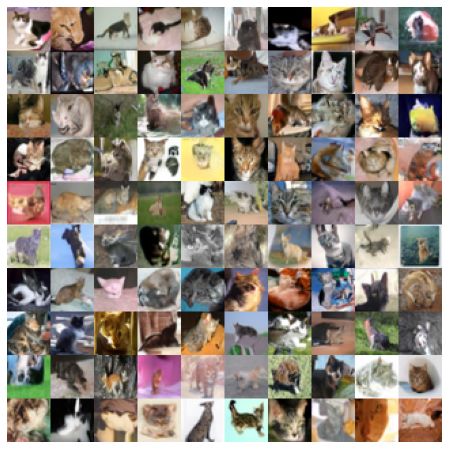

<Figure size 432x288 with 0 Axes>

In [2]:
config.sampling.batch_size = 100  # integer 
config.sampling.sampling_steps= 100 # integer
config.sampling.sampler= 'ode_sampler' #pc_sampler2, ode_sampler
config.sampling.initial_clamp= 20 
config.sampling.clamp= 20
config.sampling.fix_class= 3.# null or integer 0. ~9.
config.sampling.device ='cuda'
sample(config);


## Imputation 


Files already downloaded and verified


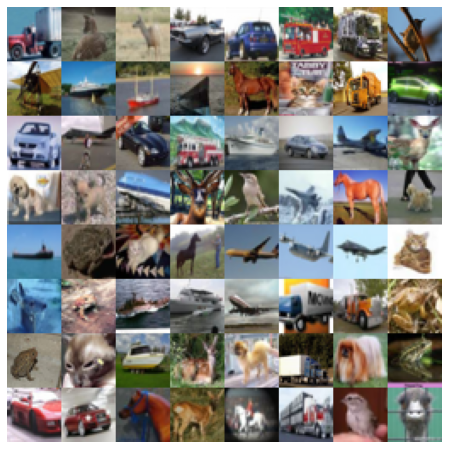

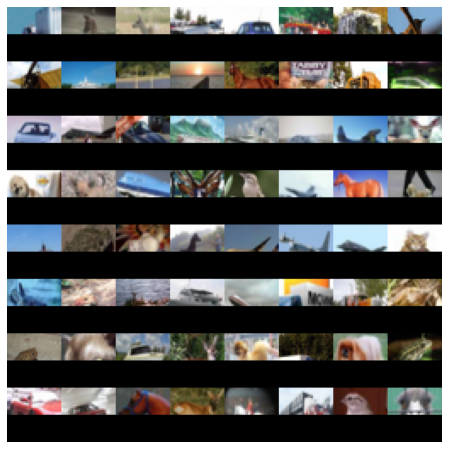

  0%|          | 0/499 [00:00<?, ?it/s]

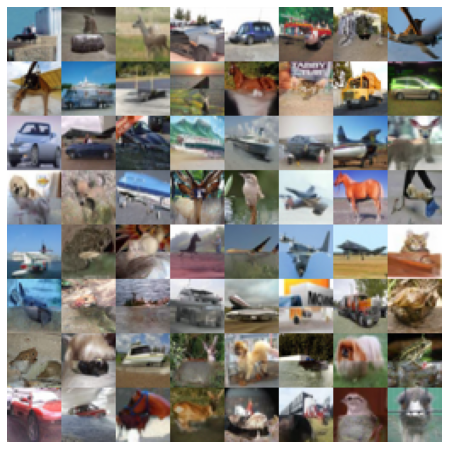

In [6]:
from imputation import *
from util import * 
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader

#parameter setting 
dataset = config.datasets.dataset
image_size = config.datasets.image_size
channels = config.datasets.channels
batch_size =64
alpha = config.Diffusion.alpha 
device = config.sampling.device
path = config.sampling.path 
transform = Compose([Resize(image_size),ToTensor()])

#dataload
dataset = CIFAR10('.', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=0, generator=torch.Generator(device=device))
batch = next(iter(data_loader))
data = batch[0].to(device)


show_samples(data, 'original_image.png')

#mask setting 
mask = torch.ones_like(data).to(device)
mask[:, :, 16:, :] = 0.
show_samples(data * mask, 'masked_image.png')

#Model setting 
sde = VPSDE(config)
score_model = get_model(config)
ckpt = torch.load(path, map_location=device)
score_model.load_state_dict(ckpt,strict=False)
score_model.to(device)
score_model.eval()

#imputating
data = 2*data-1
x =  impainted_pc_sampler2(score_model,
                sde, data*mask, mask,
                batch_size=batch_size,
                num_steps=500) #impainted_ode_sampler or impainted_pc_sampler2

x = (x+1)/2
x = x.clamp(0.0, 1.0)
show_samples(x,'impainted_image.png')